# Prototyping Settings for Simplistic DESC SRD Y1 after PGD implementation and average over 100 maps 

For reference, the DESC SRD can be found [here](https://arxiv.org/pdf/1809.01669.pdf). Appendix D2 specifies some of the analysis choices for the Y1 data. 

In particular:
- neff for lensing sources: 10 gal/arcmin^2
- sigma_e: 0.26 per component
- lmax: 3000

We will use a kappa TNG map as a reference point.

In [1]:
%pylab inline 
import tensorflow_addons as tfa
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import DifferentiableHOS as DHOS
import flowpm.scipy.interpolate as interpolate
import astropy.units as u
import jax_cosmo as jc
import pickle
from flowpm import tfpm

Populating the interactive namespace from numpy and matplotlib


In [2]:
field_size=5.
field_npix=1024
z_source = np.array([1.])
pix = field_size/field_npix
theta = pix*np.arange(field_npix)

In [3]:
import os
kmap_array=[]
def Load():
    for filename in os.listdir("/global/cscratch1/sd/dlan/plot_paper2/"):
        content =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/plot_paper2/', filename), 'rb'))
        kmap = content['map'].reshape([1, field_npix, field_npix])
        kmap_array.append(kmap)


In [4]:
Load()

In [5]:
ps_array=[]
for kmap in (kmap_array):
    l,ps=DHOS.statistics.power_spectrum(kmap[0],field_size,field_npix)
    ps_array.append(ps)


In [6]:
ps_mean=np.mean(ps_array,axis=0)

## Comparison to Analytical $halofit$ predictions computed using the jax_cosmo library

In [7]:
cosmo=jc.Planck15()
nz =jc.redshift.delta_nz(z_source)
probes = [jc.probes.WeakLensing([nz])] 
cls = jc.angular_cl.angular_cl(cosmo, l.numpy(), probes)


/global/homes/d/dlan/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5293: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


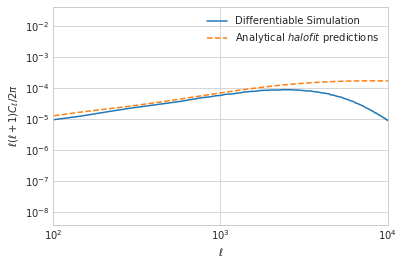

In [8]:
style.use('seaborn-whitegrid')
loglog(l, l*(l+1)*ps_mean/(2*np.pi),label='Differentiable Simulation')
loglog(l, l*(l+1)*cls[0]/(2*np.pi),'--',label='Analytical $halofit$ predictions')
xlim(1e2,1e4)
ylim(4e-9,4e-2)
# axvline(300)
# axvline(3000)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
legend()
#savefig('cl_comp1.png',dpi=250)

## Comparison to kappa TNG

For comparison, we are using this map at redshift 1 from the kappa TNG simulations.

In [9]:
kTNG_array=[]
def Load_2():
    for filename in os.listdir("/global/cfs/cdirs/lsst/groups/WL/projects/wl-massmap/kappaTNG/kappaTNG-Dark"):
        fname=os.path.join('/global/cfs/cdirs/lsst/groups/WL/projects/wl-massmap/kappaTNG/kappaTNG-Dark',  filename+"/run001/kappa23.dat")
        with open(fname, 'rb') as f:
            dummy = np.fromfile(f, dtype="int32", count=1)
            kappaTNG = np.fromfile(f, dtype="float", count=field_npix* field_npix)
            dummy = np.fromfile(f, dtype="int32", count=1)
        kappaTNG = kappaTNG.reshape((field_npix, field_npix))
        kTNG_array.append(kappaTNG)


In [10]:
Load_2() 

In [11]:
ps_kTNG_array=[]
for kmap in (kTNG_array):
    l,ps=DHOS.statistics.power_spectrum(kmap,field_size,field_npix)
    ps_kTNG_array.append(ps)

In [12]:
ps_kTNGmean=np.mean(ps_kTNG_array,axis=0)

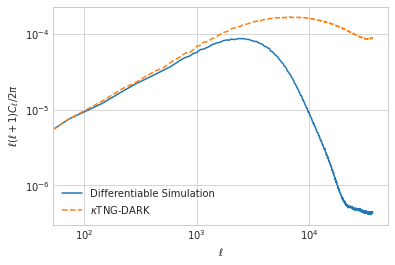

In [13]:
style.use('seaborn-whitegrid')
loglog(l, l*(l+1)*ps_mean/(2*np.pi),label='Differentiable Simulation')
loglog(l, l*(l+1)*ps_kTNGmean/(2*np.pi),'--',label='$\kappa$TNG-DARK')
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
legend()
#savefig('cl_comp1.png',dpi=250)

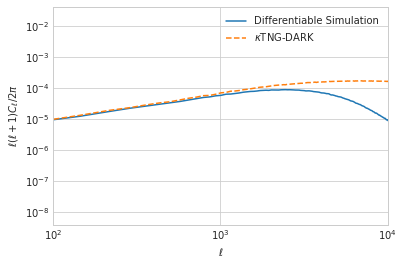

In [14]:
style.use('seaborn-whitegrid')
loglog(l, l*(l+1)*ps_mean/(2*np.pi),label='Differentiable Simulation')
loglog(l, l*(l+1)*ps_kTNGmean/(2*np.pi),'--',label='$\kappa$TNG-DARK')
xlim(1e2,1e4)
ylim(4e-9,4e-2)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
legend()
#savefig('cl_comp1.png',dpi=250)

In [15]:
ps_kTNGstd=np.std(ps_kTNG_array,axis=0)

Text(0.5, 1.0, 'Comparison to $\\kappa$$TNG-$DARK')

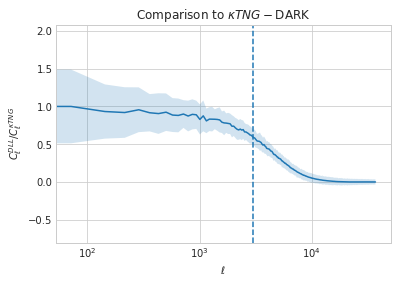

In [16]:
y=ps_mean/ps_kTNGmean
ci=ps_kTNGstd
fig, ax = plt.subplots()
plt.semilogx(l, y)
ax.fill_between(l, y-ci/ps_kTNGmean, y+ci/ps_kTNGmean, alpha=.2)
ylabel('$C_{\ell}^{DLL}/C_\ell^{\kappa TNG}$')
xlabel('$\ell$')
axvline(3000, ls='--')
title('Comparison to $\kappa$$TNG-$DARK')

So, obvioulsy our 128^3 simulation is not as precise as kappa TNG, but we won't be working at the native 0.3 arcmin resolution anyway, in practice we'll have noise and smoothing.

So let's see how much smoothing gets us in the right ball park.

In [17]:
ngal = 10                          # gal/arcmin **2
pix_scale =field_size/field_npix*60              # arcmin
ngal_per_pix = ngal * pix_scale**2 # galaxies per pixels
sigma_e = 0.26 / sqrt(2 * ngal_per_pix) # Rescaled noise sigma

In [18]:
sigma_pix_2ar=2/pix_scale

Populating the interactive namespace from numpy and matplotlib


(-0.5, 1023.5, 1023.5, -0.5)

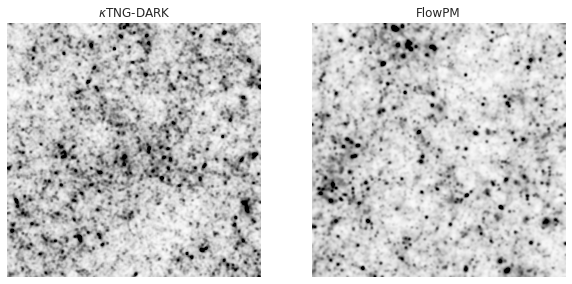

In [19]:
%pylab inline 
# Here is what it looks like with smoothin 
figure(figsize=[10,20])
subplot(121)
title('$\kappa$TNG-DARK')
imshow(tfa.image.gaussian_filter2d(kTNG_array[0],11,sigma=sigma_pix_2ar), vmax=0.05)
axis('off')
subplot(122)
title('FlowPM')
imshow(tfa.image.gaussian_filter2d(kmap_array[0][0],11,sigma=sigma_pix_2ar), vmax=0.05)
axis('off')

In [20]:
ps_FLP_array_2arc=[]
for kmap in (kmap_array):
    l, ps_FLP_2arc= DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(kmap[0],11,sigma=sigma_pix_2ar),field_size,field_npix)
    ps_FLP_array_2arc.append(ps_FLP_2arc)
ps_FLP_2arc_mean=np.mean(ps_FLP_array_2arc,axis=0)

In [21]:
ps_TNG_array_2arc=[]
for kmap in (kTNG_array):
    l, ps_kTNG_2arc= DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(kmap,11,sigma=sigma_pix_2ar),field_size,field_npix)
    ps_TNG_array_2arc.append(ps_kTNG_2arc)
ps_kTNG_2ar_mean=np.mean(ps_TNG_array_2arc,axis=0)

Text(0.5, 1.0, 'Comparison to $\\kappa$TNG-DARK with 2-arcmin smoothing')

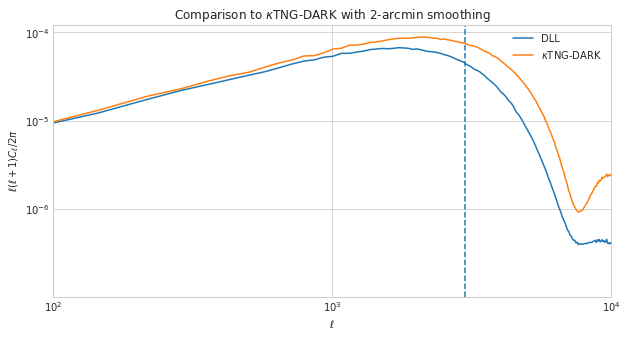

In [22]:
figure(figsize=[10,5])
loglog(l, l*(l+1)*ps_FLP_2arc_mean/(2*np.pi), label='DLL')
loglog(l, l*(l+1)*ps_kTNG_2ar_mean/(2*np.pi), label='$\kappa$TNG-DARK')
legend()
axvline(3000, ls='--')
xlim(1e2,1e4)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
title('Comparison to $\kappa$TNG-DARK with 2-arcmin smoothing')

## Adding noise

We'll now try to get to a realistic setting that matches some of the SRD Y1 settings.

In [23]:
ps_FLP_array_2arc_n=[]
for kmap in (kmap_array):
    kmap= kmap[0]+ sigma_e * randn(1024,1024), 5*u.deg
    l, ps_FLP_2arc_n= DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(kmap[0],11,sigma=sigma_pix_2ar),field_size,field_npix)
    ps_FLP_array_2arc_n.append(ps_FLP_2arc_n)
ps_FLP_2arc_n_mean=np.mean(ps_FLP_array_2arc_n,axis=0)

In [24]:
ps_TNG_array_2arc_n=[]
for kmap in (kTNG_array):
    knTNG_n = kmap+ sigma_e * randn(1024,1024), 5*u.deg
    l, ps_kTNG_2arc_n= DHOS.statistics.power_spectrum(tfa.image.gaussian_filter2d(knTNG_n[0],11,sigma=sigma_pix_2ar),field_size,field_npix)
    ps_TNG_array_2arc_n.append(ps_kTNG_2arc_n)
ps_kTNG_2arc_n_mean=np.mean(ps_TNG_array_2arc_n,axis=0)

Text(0.5, 1.0, 'FlowPM')

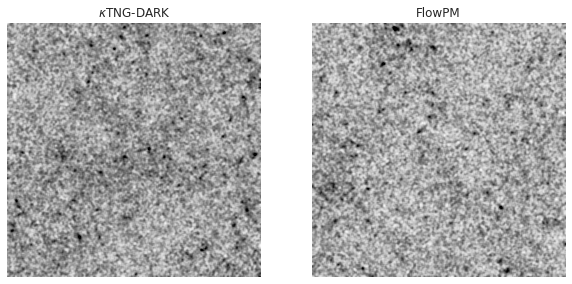

In [25]:
knTNG_n = kTNG_array[0]+ sigma_e * randn(1024,1024), 5*u.deg
kmap_n=kmap_array[0][0]+ sigma_e * randn(1024,1024)
# Here is what it looks like with noise 
figure(figsize=[10,20])
subplot(121)
title('$\kappa$TNG-DARK')
imshow(tfa.image.gaussian_filter2d(knTNG_n[0],11,sigma=sigma_pix_2ar), vmax=0.1)
axis('off')
subplot(122)
title('FlowPM')
imshow(tfa.image.gaussian_filter2d(kmap_n,11,sigma=sigma_pix_2ar), vmax=0.1)
axis('off')
title('FlowPM')



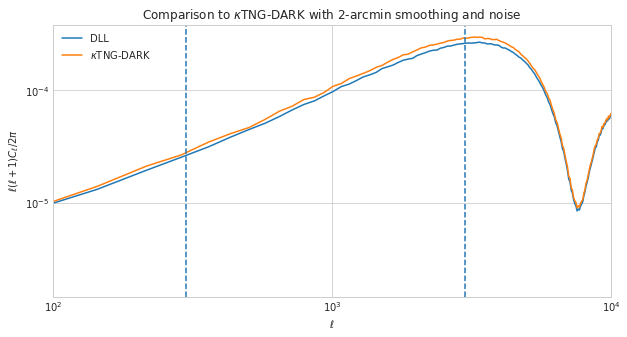

In [26]:
figure(figsize=[10,5])
loglog(l, l*(l+1)*ps_FLP_2arc_n_mean/(2*np.pi), label='DLL')
loglog(l, l*(l+1)*ps_kTNG_2arc_n_mean/(2*np.pi), label='$\kappa$TNG-DARK ')
axvline(3000, ls='--')
axvline(300,ls='--')
xlim(1e2,1e4)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
title('Comparison to $\kappa$TNG-DARK with 2-arcmin smoothing and noise')
legend()


In [27]:
ps_kTNG_2arc_n_std=np.std(ps_TNG_array_2arc_n,axis=0)

Text(0.5, 1.0, 'Comparison to $\\kappa$$TNG-$DARK 2-arcmin smoothing and noise')

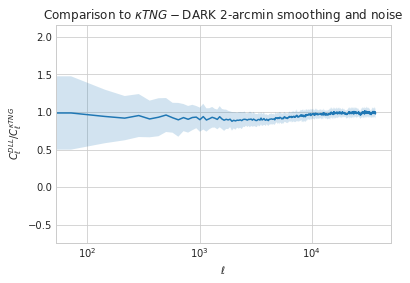

In [28]:
y=ps_FLP_2arc_n_mean/ps_kTNG_2arc_n_mean
ci=ps_kTNG_2arc_n_std
fig, ax = plt.subplots()
plt.semilogx(l, y)
ax.fill_between(l, y-ci/ps_kTNG_2arc_n_mean, y+ci/ps_kTNG_2arc_n_mean, alpha=.2)
ylabel('$C_{\ell}^{DLL}/C_\ell^{\kappa TNG}$')
xlabel('$\ell$')
title('Comparison to $\kappa$$TNG-$DARK 2-arcmin smoothing and noise')

## Let's also compare native peak counts

In [29]:
bins_=tf.convert_to_tensor([-0.09736419, -0.06226693, -0.02716974,  0.00792749,  0.0430247 ,
        0.07812194,  0.11321917,  0.1483164 ])

In [30]:
counts_FLP_array=[]

for kmap in (kmap_array):
    counts_FLP,bins_=DHOS.statistics.peaks_histogram_tf(kmap[0],bins_)
    counts_FLP_array.append(counts_FLP)
    
center_ = (bins_[:-1] + bins_[1:]) / 2
counts_FLP_mean=np.mean(counts_FLP_array,axis=0)

In [31]:
counts_kTNG_array=[]
for kmap in (kTNG_array):
    counts_TNG, bins_TNG=DHOS.statistics.peaks_histogram_tf(np.float32(kmap),bins_)
    counts_kTNG_array.append(counts_TNG)
counts_kTNG_mean=np.mean(counts_kTNG_array,axis=0)

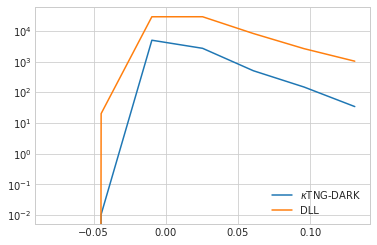

In [32]:
semilogy(center_, counts_FLP_mean, label='$\kappa$TNG-DARK ')
semilogy(center_, counts_kTNG_mean, label='DLL')
legend()

In [33]:
counts_kTNG_std=np.std(counts_kTNG_array,axis=0)

<ipython-input-34-4b09a655ec09>:1: RuntimeWarning: invalid value encountered in true_divide
  y=(counts_FLP_mean-counts_kTNG_mean)/counts_kTNG_mean
<ipython-input-34-4b09a655ec09>:5: RuntimeWarning: invalid value encountered in true_divide
  ax.fill_between(center_, (y-ci/counts_kTNG_mean), y+ci/counts_kTNG_mean, color='red', alpha=.2)


Text(0.5, 0, '$\\kappa$')

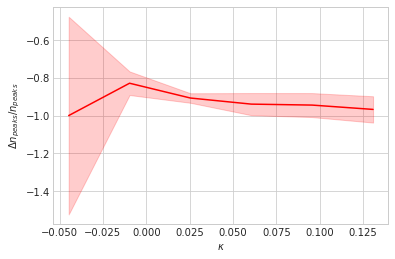

In [34]:
y=(counts_FLP_mean-counts_kTNG_mean)/counts_kTNG_mean
ci=counts_kTNG_std
fig, ax = plt.subplots()
ax.plot(center_, y, label='$\kappa$TNG-DARK ',color='red')
ax.fill_between(center_, (y-ci/counts_kTNG_mean), y+ci/counts_kTNG_mean, color='red', alpha=.2)
ylabel('$\Delta$$n_{peaks}/n_{peaks}$')
xlabel('$\kappa$')

### Adding noise and smoothing

In [36]:
counts_FLP_array_2n=[]
for kmap in (kmap_array):
    kmap= kmap[0]+ sigma_e * randn(1024,1024), 5*u.deg
    counts_FLP,bins_=DHOS.statistics.peaks_histogram_tf(tfa.image.gaussian_filter2d(np.float32(kmap[0]),11,sigma=sigma_pix_2ar),bins_)
    counts_FLP_array_2n.append(counts_FLP)
counts_FLP_mean_2n=np.mean(counts_FLP_array_2n,axis=0)

In [37]:
counts_kTNG_array_2n=[]
for kmap in (kTNG_array):
    knTNG_n = kmap+ sigma_e * randn(1024,1024), 5*u.deg
    counts_TNG, bins_=DHOS.statistics.peaks_histogram_tf(tfa.image.gaussian_filter2d(np.float32(knTNG_n[0]),11,sigma=sigma_pix_2ar),bins_)
    counts_kTNG_array_2n.append(counts_TNG)
counts_kTNG_mean_2n=np.mean(counts_kTNG_array_2n,axis=0)

Text(0.5, 0, '$\\kappa$')

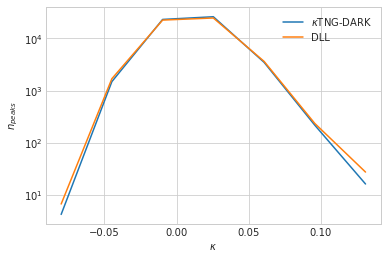

In [38]:
semilogy(center_, counts_FLP_mean_2n, label='$\kappa$TNG-DARK ')
semilogy(center_, counts_kTNG_mean_2n, label='DLL')
legend()
ylabel('$n_{peaks}$')
xlabel('$\kappa$')


In [39]:
counts_kTNG_std_2n=np.std(counts_kTNG_array_2n,axis=0)

Text(0.5, 0, '$\\kappa$')

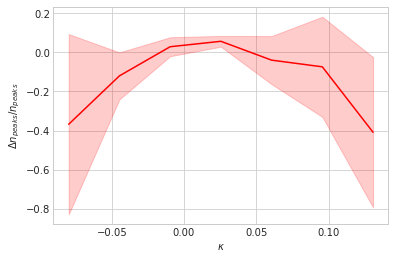

In [40]:
y=(counts_FLP_mean_2n-counts_kTNG_mean_2n)/counts_kTNG_mean_2n
ci=counts_kTNG_std_2n
fig, ax = plt.subplots()
ax.plot(center_, y, label='$\kappa$TNG-DARK ',color='red')
ax.fill_between(center_, (y-ci/counts_kTNG_mean_2n), y+ci/counts_kTNG_mean_2n, color='red', alpha=.2)
ylabel('$\Delta$$n_{peaks}/n_{peaks}$')
xlabel('$\kappa$')

## Let's also compare the l1norm

In [41]:
l1norm_FLO_array=[] 
for kmap in (kmap_array):
    l1norm_FLO= DHOS.statistics.l1norm(kmap, nbins=7, value_range=[-0.05, 0.05])
    l1norm_FLO_array.append(l1norm_FLO)
l1norm_FLO_mean=np.mean(l1norm_FLO_array,axis=0)

In [42]:
l1norm_kTNG_array=[] 
for kmap in (kTNG_array):
    kmap=tf.expand_dims(kmap,axis=0)
    l1norm_kTNG= DHOS.statistics.l1norm(np.float32(kmap), nbins=7, value_range=[-0.05, 0.05])
    l1norm_kTNG_array.append(l1norm_kTNG)
l1norm_kTNG_mean=np.mean(l1norm_kTNG_array,axis=0)

Text(0.5, 0, '$l_{1norm}$')

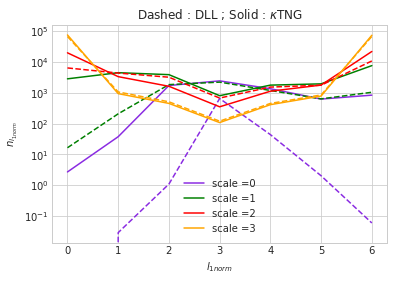

In [44]:
color_palette =["blueviolet","green","red","orange"]

for i in range(4):
    semilogy(l1norm_kTNG_mean[i][0], label='scale =' +str(i), color=color_palette[i])
    semilogy(l1norm_FLO_mean[i][0],'--',color=color_palette[i])
    legend()
title("Dashed : DLL ; Solid : $\kappa$TNG")
ylabel('$n_{l_{1norm}}$')
xlabel('$l_{1norm}$')

In [45]:
l1norm_kTNG_std_=np.std(l1norm_kTNG_array,axis=0)

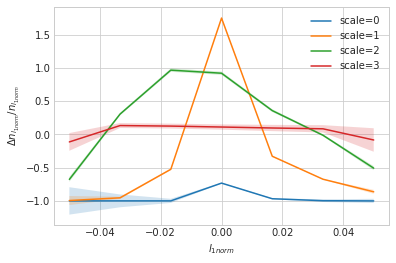

In [46]:
x=np.linspace(-0.05, 0.05,7)
fig, ax = plt.subplots()
for i in range(4):
    y=(l1norm_FLO_mean[i][0]-l1norm_kTNG_mean[i][0])/l1norm_kTNG_mean[i][0]
    ci=l1norm_kTNG_std_[i][0]  
    ax.plot(x,y,label='scale='+str(i))
    ax.fill_between(x,y-ci/l1norm_kTNG_mean[i][0], y+ci/l1norm_kTNG_mean[i][0], alpha=.2)
ylabel('$\Delta$$n_{l_{1norm}}/n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend()

### Adding noise and smoothing

In [47]:
l1norm_FLO_array_2n=[] 
for kmap in (kmap_array):
    kmap= kmap+ sigma_e * randn(1024,1024), 5*u.deg
    kmap=tfa.image.gaussian_filter2d(np.float32(kmap[0][0]),11,sigma=sigma_pix_2ar)
    kmap=tf.expand_dims(kmap, axis=0)
    l1norm_FLO= DHOS.statistics.l1norm(kmap, nbins=7, value_range=[-0.05, 0.05])
    l1norm_FLO_array_2n.append(l1norm_FLO)
l1norm_FLO_mean_n_2arc=np.mean(l1norm_FLO_array_2n,axis=0)

In [48]:
l1norm_kTNG_array_2n=[] 
for kmap in (kTNG_array):
    kmap= kmap+ sigma_e * randn(1024,1024), 5*u.deg
    kmap=tfa.image.gaussian_filter2d(np.float32(kmap[0]),11,sigma=sigma_pix_2ar)
    kmap=tf.expand_dims(kmap, axis=0)
    l1norm_kTNG= DHOS.statistics.l1norm(kmap, nbins=7, value_range=[-0.05, 0.05])
    l1norm_kTNG_array_2n.append(l1norm_kTNG)
l1norm_kTNG_mean_n_2arc=np.mean(l1norm_kTNG_array_2n,axis=0)

Text(0.5, 0, '$l_{1norm}$')

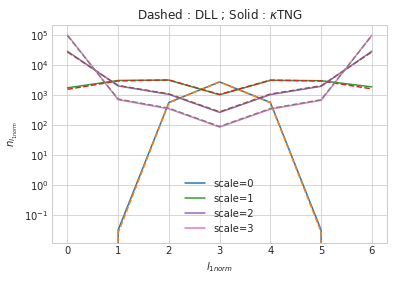

In [54]:
for i in range(4):
    semilogy(l1norm_kTNG_mean_n_2arc[i][0], label='scale='+str(i))
    semilogy(l1norm_FLO_mean_n_2arc[i][0],'--')
    legend()
title("Dashed : DLL ; Solid : $\kappa$TNG")
ylabel('$n_{l_{1norm}}$')
xlabel('$l_{1norm}$')

In [55]:
l1norm_kTNG_std_n_2arc=np.std(l1norm_kTNG_array_2n,axis=0)

<ipython-input-56-2c931f8af21d>:4: RuntimeWarning: invalid value encountered in true_divide
  y=(l1norm_FLO_mean_n_2arc[i][0]-l1norm_kTNG_mean_n_2arc[i][0])/l1norm_kTNG_mean_n_2arc[i][0]
<ipython-input-56-2c931f8af21d>:7: RuntimeWarning: invalid value encountered in true_divide
  ax.fill_between(x,y-ci/l1norm_kTNG_mean_n_2arc[i][0], y+ci/l1norm_kTNG_mean_n_2arc[i][0], alpha=.2)


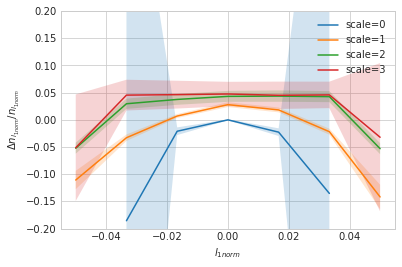

In [56]:
x=np.linspace(-0.05, 0.05,7)
fig, ax = plt.subplots()
for i in range(4):
    y=(l1norm_FLO_mean_n_2arc[i][0]-l1norm_kTNG_mean_n_2arc[i][0])/l1norm_kTNG_mean_n_2arc[i][0]
    ci=l1norm_kTNG_std_n_2arc[i][0]  
    ax.plot(x,y,label='scale='+str(i))
    ax.fill_between(x,y-ci/l1norm_kTNG_mean_n_2arc[i][0], y+ci/l1norm_kTNG_mean_n_2arc[i][0], alpha=.2)
ylim(-0.20,0.20)
ylabel('$\Delta$$n_{l_{1norm}}/n_{l_{1norm}}$')
xlabel('$l_{1norm}$')
legend()